In [248]:
using BAT, DensityInterface
using PartonDensity
using QCDNUM
using Plots, Random, Distributions, ValueShapes, ParallelProcessingTools
using StatsBase, LinearAlgebra
using SpecialFunctions, Printf
const sf = SpecialFunctions;
using DelimitedFiles
using LaTeXStrings
using HypothesisTests
using Statistics


gr(fmt=:png);

# Results
seedtxt="42"
samplename = string("simsamples-", seedtxt, ".h5")

samples_data = bat_read(samplename).result;

simname = string("simulation-", seedtxt, ".h5")
pdf_params, sim_data=pd_read_sim(simname)

counts_obs_ep_data=sim_data["counts_obs_ep"]
counts_obs_em_data=sim_data["counts_obs_em"]

nbins = size(counts_obs_ep_data)[1]


prob_ep_gen = zeros(nbins)
prob_em_gen = zeros(nbins)

prob_ep_sim = zeros(nbins)
prob_em_sim = zeros(nbins)

prob_ep_data = zeros(nbins)
prob_em_data = zeros(nbins)

mode_pars_data = mode(samples_data)


# As in PDF-fit-dirichlet.ipynb
qcdnum_grid = QCDNUMGrid(x_min=[1.0e-3, 1.0e-1, 5.0e-1], x_weights=[1, 2, 2], nx=100,
                         qq_bounds=[1.0e2, 3.0e4], qq_weights=[1.0, 1.0], nq=50, 
                         spline_interp=3)
qcdnum_params = QCDNUMParameters(order=2, α_S=0.118, q0=100.0, grid=qcdnum_grid,
                                 n_fixed_flav=5, iqc=1, iqb=1, iqt=1, weight_type=1);
splint_params = SPLINTParameters();
quark_coeffs = QuarkCoefficients()

QuarkCoefficients
  proup: Array{Float64}((13,)) [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]
  prodn: Array{Float64}((13,)) [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]
  valup: Array{Float64}((13,)) [0.0, 0.0, -1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]
  valdn: Array{Float64}((13,)) [0.0, -1.0, 0.0, -1.0, 0.0, -1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]


In [249]:
q2_edges_all = Any[]
x_edges_all = Any[]
for i in 1:nbins
    (q2_edges, x_edges) = get_bin_info(i, quiet=true);
    push!(q2_edges_all, q2_edges)
    push!(x_edges_all, x_edges)
end

q2_edges_unique = copy(q2_edges_all)
n_q2_bins = length(unique!(q2_edges_unique))

# get x, counts for each q2 range
counts_em_qsel = Any[]
counts_ep_qsel = Any[]
x_values = Any[]
for q2r in 1:n_q2_bins
    bin_sel = findall(==(q2_edges_unique[q2r]), q2_edges_all)
    push!(counts_em_qsel, counts_obs_em_data[bin_sel])
    push!(counts_ep_qsel, counts_obs_ep_data[bin_sel])
    push!(x_values, [mean(_) for _ in x_edges_all[bin_sel]])
end

In [250]:
Ns = 10000 # Number of samples from posterior
sub_samples = BAT.bat_sample(samples_data, BAT.OrderedResampling(nsamples=Ns)).result;

[ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}


In [251]:
forward_model_init(qcdnum_params, splint_params)

counts_em_sampled = zeros(UInt64, (length(sub_samples), nbins))
counts_ep_sampled = zeros(UInt64, (length(sub_samples), nbins))
chisqep = zeros( length(sub_samples))
chisqem = zeros( length(sub_samples))

rng = MersenneTwister(42);
sys_err_params = rand(rng, MvNormal(zeros(PartonDensity.nsyst), zeros(PartonDensity.nsyst)))

for s in eachindex(sub_samples)

    pdf_params_s = DirichletPDFParams(K_u=sub_samples.v.K_u[s], K_d=sub_samples.v.K_d[s], K_q=sub_samples.v.K_q[s],
                                      λ_g1=sub_samples.v.λ_g1[s], 
                                      λ_g2=sub_samples.v.λ_g2[s],
                                      K_g=sub_samples.v.K_g[s], 
                                      λ_q=sub_samples.v.λ_q[s], 
                                      θ=Vector(sub_samples.v.θ[s]))
        
    counts_ep_pred_s, counts_em_pred_s = forward_model(pdf_params_s,    
                                                              qcdnum_params, 
                                                              splint_params,
                                                              quark_coeffs, 
                                                              sys_err_params)
    
    for j in 1:nbins
        
        counts_ep_pred_s[j] *= 1 + 0.018 * sub_samples.v.Beta1[s]
        counts_em_pred_s[j] *= 1 + 0.018 * sub_samples.v.Beta2[s]
        
        counts_em_sampled[s, j] = rand(Poisson(counts_em_pred_s[j]))
        counts_ep_sampled[s, j] = rand(Poisson(counts_ep_pred_s[j]))

        chisqep[s]+=(counts_ep_pred_s[j]-counts_ep_sampled[s, j])^2/counts_ep_pred_s[j]
        chisqem[s]+=(counts_em_pred_s[j]-counts_em_sampled[s, j])^2/counts_em_pred_s[j]

    end
    
end

  +---------------------------------------------------------------------+   
  |                                                                     |   
  |    If you use QCDNUM, please refer to:                              |   
  |                                                                     |   
  |    M. Botje, Comput. Phys. Commun. 182(2011)490, arXiV:1005.1481    |   
  |                                                                     |   
  +---------------------------------------------------------------------+   
  
  

 FILLWT: start unpolarised weight calculations
 Subgrids    3 Subgrid points   15   50   75
 Pij LO
 Pij NLO
 Pij NNLO
 Aij LO
 Aij NLO
 Aij NNLO
 FILLWT: weight calculations completed


 ZMFILLW: start weight calculations   4  38   0   0
 ZMFILLW: calculations completed


In [252]:
#
# Chi squared for the actual data
#
pdfpars(params)=   DirichletPDFParams(
    K_u=params.K_u, K_d=params.K_d, λ_g1=params.λ_g1, λ_g2=params.λ_g2, K_q=params.K_q,
    K_g=params.K_g, λ_q=params.λ_q, θ=Vector(params.θ))
mode_pars_data = mode(samples_data)
println(mode_pars_data)

pdf_params = pdfpars(mode_pars_data)
println(pdf_params)
sys_err_params =[
    mode_pars_data.beta0_1,mode_pars_data.beta0_2,mode_pars_data.beta0_3,mode_pars_data.beta0_4,
    mode_pars_data.beta0_5,mode_pars_data.beta0_6,mode_pars_data.beta0_7,mode_pars_data.beta0_8]

        counts_pred_ep_data, counts_pred_em_data = forward_model(pdf_params,
            qcdnum_params, splint_params, quark_coeffs, sys_err_params)

for i in 1:nbins     
    counts_pred_ep_data[i] =counts_pred_ep_data[i]*(1+0.018*mode_pars_data.Beta1)
    counts_pred_em_data[i] =counts_pred_em_data[i]*(1+0.018*mode_pars_data.Beta2)
end


(θ = [0.2145354942590707, 0.1306276940556801, 0.21264343617556192, 0.28056601841968676, 0.11086577612520075, 0.014176970631510626, 0.007068035871884069, 0.029516574461016687, 3.884117880095027e-13], K_u = 3.547755544097097, K_d = 3.7700807514524914, K_q = 4.480051710336797, λ_g1 = 0.5454228714467175, λ_g2 = -0.7850713093206632, λ_q = -0.5611205932175503, K_g = 4.833764713202773, Beta1 = -0.36446270358015154, Beta2 = -0.6963254034310045, beta0_1 = 1.0019056083985936, beta0_2 = 0.7564249531830458, beta0_3 = 0.9897087954761639, beta0_4 = 0.27142684286639923, beta0_5 = 2.6708309986767875, beta0_6 = 0.17834526606494014, beta0_7 = 0.35020992471602624, beta0_8 = 0.33389519211961155)
DirichletPDFParams{Float64, Vector{Float64}}
  param_type: Int64 2
  θ: Array{Float64}((9,)) [0.2145354942590707, 0.1306276940556801, 0.21264343617556192, 0.28056601841968676, 0.11086577612520075, 0.014176970631510626, 0.007068035871884069, 0.029516574461016687, 3.884117880095027e-13]
  K_u: Float64 3.547755544097

In [253]:
#
# Calculate the Poisson probabilities for the different data results
#
chisqep_data=0.
chisqem_data=0.
        for j in 1:nbins
            pred=counts_pred_ep_data[j]   
            best=floor(counts_pred_ep_data[j])
            prob_ep_data[j] = pdf(Poisson(pred), counts_obs_ep_data[j])/pdf(Poisson(pred), best)
            chisqep_data+=(counts_obs_ep_data[j]-pred)^2/pred
            if ( (counts_obs_ep_data[j]-pred)^2/pred>4) 
                get_bin_info(j) 
                println(j," positron ",pred," ",counts_obs_ep_data[j]," ",(counts_obs_ep_data[j]-pred)^2/pred)
            end
    
            pred=counts_pred_em_data[j]
            best=floor(counts_pred_em_data[j])
            prob_em_data[j] = pdf(Poisson(pred), counts_obs_em_data[j])/pdf(Poisson(pred), best)
            chisqem_data+=(counts_obs_em_data[j]-pred)^2/pred
            if ( (counts_obs_em_data[j]-pred)^2/pred>4) 
                get_bin_info(j) 
                println(j," electron ",pred," ",counts_obs_em_data[j]," ",(counts_obs_em_data[j]-pred)^2/pred)
            end



#           
       end
println(chisqep_data," ",chisqem_data)

33 electron 214.9722726228448 249 5.386211981325775
60 electron 162.98695762146522 123 9.810335766463037
68 positron 131.21081857585176 159 5.88547966247007
74 positron 57.92421804777795 77 6.282095285059782
75 positron 45.29526408885633 60 4.773771884678682
97 electron 112.00344017313499 139 6.507070152121222
109 electron 69.78923572064576 51 5.058593568485694
110 electron 65.12058765017335 82 4.375184124658649
124 electron 33.640170284282625 46 4.541159848792601
127 electron 12.471157043314145 20 4.545165782899552
132 electron 64.43308132894298 86 7.218838077747702
138 positron 5.463655549931992 0 5.463655549931992
127.8043615533414 163.97403636708455


┌ Info: ZEUS detector bin
│   n = 33
│   BinQ2low[n] = 1100
│   BinQ2high[n] = 1300
│   Binxlow[n] = 0.2
└   Binxhigh[n] = 0.24
┌ Info: ZEUS detector bin
│   n = 60
│   BinQ2low[n] = 1800
│   BinQ2high[n] = 2100
│   Binxlow[n] = 0.17
└   Binxhigh[n] = 0.21
┌ Info: ZEUS detector bin
│   n = 68
│   BinQ2low[n] = 2100
│   BinQ2high[n] = 2400
│   Binxlow[n] = 0.1
└   Binxhigh[n] = 0.13
┌ Info: ZEUS detector bin
│   n = 74
│   BinQ2low[n] = 2100
│   BinQ2high[n] = 2400
│   Binxlow[n] = 0.34
└   Binxhigh[n] = 0.46
┌ Info: ZEUS detector bin
│   n = 75
│   BinQ2low[n] = 2100
│   BinQ2high[n] = 2400
│   Binxlow[n] = 0.46
└   Binxhigh[n] = 1.0
┌ Info: ZEUS detector bin
│   n = 97
│   BinQ2low[n] = 3200
│   BinQ2high[n] = 3800
│   Binxlow[n] = 0.13
└   Binxhigh[n] = 0.16
┌ Info: ZEUS detector bin
│   n = 109
│   BinQ2low[n] = 3800
│   BinQ2high[n] = 4500
│   Binxlow[n] = 0.19
└   Binxhigh[n] = 0.23
┌ Info: ZEUS detector bin
│   n = 110
│   BinQ2low[n] = 3800
│   BinQ2high[n] = 4500
│   Binxlow[n]

In [254]:
countep=0
countem=0
count_tot=0
ncounts=0

for s in eachindex(sub_samples)
    ncounts+=1
    if (chisqep[s]>chisqep_data) countep+=1 end
    if (chisqem[s]>chisqem_data) countem+=1 end
    if (chisqem[s]+chisqep[s]>chisqem_data+chisqep_data) count_tot+=1 end

end
pvep=string(float(countep)/ncounts)
pvem=string(float(countem)/ncounts)
println(" p-value for ep fit: ",pvep," p-value for em fit: ",pvem," p-value for total fit: ",float(count_tot)/ncounts) 


 p-value for ep fit: 0.9257341961174714 p-value for em fit: 0.2570433051269288 p-value for total fit: 0.705226480836237


In [255]:
p1=histogram(chisqep,bins=100,xlabel=L"\chi^2_P", ylabel="counts",title=L"e$^+$P")
p1=plot!([chisqep_data],seriestype = :vline,lw=5,legend=:none)
p2=histogram(chisqem,bins=50:2:250,legend=:false,xlabel=L"\chi^2_P", ylabel="counts",title=L"e$^-$P")
#histogram!(chisqem,bins=100)
#vline!(chisqem_data,color="red",mw=1)
p2=plot!([chisqem_data],seriestype = :vline,lw=5)
plot(p1,p2,layout=(2,1))

In [256]:
filename = string("chisq-pvalue-", seedtxt, ".pdf")
savefig(filename)

"/Users/AllenCCaldwell/F2/PRDpaper/chisq-pvalue-42.pdf"

In [257]:
# Use +2 to avoid lightest colors (not easy to see)
color_scheme = :viridis
font_family = "Computer Modern"
c1 = :teal
c2 = :royalblue4
c3 = :midnightblue
c4 = :grey
cmap = palette(color_scheme, n_q2_bins+2)
Plots.scalefontsizes()
Plots.scalefontsizes(1.2);
alpha = 0.6
prior_alpha = 0.2;

In [258]:
# Get some prior samples for plotting
prior = NamedTupleDist(
    θ = Dirichlet([20., 10., 20., 20., 5.,2.5, 1.5, 1.5, 0.5]),
    K_u = Truncated(Normal(3.5, 0.5), 2, 5),
    K_d = Truncated(Normal(3.5, 0.5), 2, 5),
#    K_q = Truncated(Normal(4., 1.5), 3., 10.),
    K_q = Truncated(Normal(6., 1.5), 3., 10.),
    λ_g1 = Uniform(0., 1.),
    λ_g2 = Uniform(-1.0, -0.1),
    λ_q = Uniform(-1.0, -0.1),
#    K_g =  Truncated(Normal(4., 1.5), 2., 7.),
    K_g =  Truncated(Normal(5., 1.5), 2., 7.),
    Beta1 =  Truncated(Normal(0, 1), -5, 5),
    Beta2 =  Truncated(Normal(0, 1), -5, 5),
    beta0_1=Truncated(Normal(0, 1), -5, 5),
    beta0_2=Truncated(Normal(0, 1), -5, 5),
    beta0_3=Truncated(Normal(0, 1), -5, 5),
    beta0_4=Truncated(Normal(0, 1), -5, 5),
    beta0_5=Truncated(Normal(0, 1), -5, 5),
    beta0_6=Truncated(Normal(0, 1), -5, 5),
    beta0_7=Truncated(Normal(0, 1), -5, 5),
    beta0_8=Truncated(Normal(0, 1), -5, 5)
);
prior_samples=bat_sample(prior).result;

[ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
┌ Info: Using sampling algorithm IIDSampling
└   nsamples: Int64 100000


In [259]:
xlims_K_u = (2.0, 7.0) # (3.2, 4.4)
xlims_D_u = (0., 0.5) # (0.29, 0.37)
xlims_K_d = (2.0, 7.0) # (3.2, 4.4)
xlims_D_d = (0., 0.5) # (0.29, 0.37)
intervals = [0.68, 0.95]
labels = [L"~~\mathrm{Posterior}~68~\%", L"~~\mathrm{Posterior}~95~\%"]
prior_labels = [L"~~\mathrm{Prior}~68~\%", L"~~\mathrm{Prior}~95~\%"]
colors = [c3, c1]
prior_colors = [:grey40, :grey50]

2-element Vector{Symbol}:
 :grey40
 :grey50

[0.2278612118073537, 0.10357327809425168, 0.24857586742620402, 0.24857586742620402, 0.10357327809425168, 0.05178663904712584, 0.010357327809425169, 0.005178663904712584, 0.0005178663904712584]


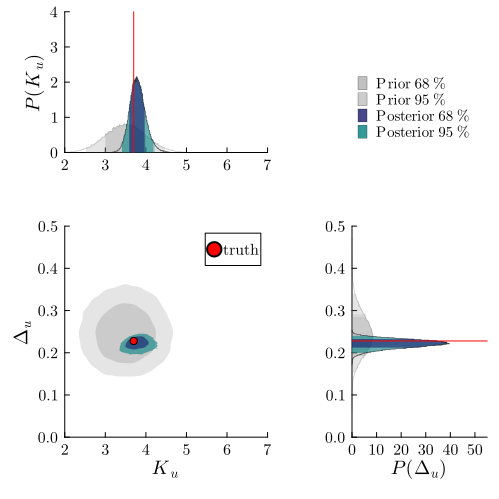

In [260]:
θ_true=[0.22, 0.10, 0.24, 0.24, 0.10,0.05, 0.01, 0.005, 0.0005]
θ_sum=sum(θ_true[1:9])
θ_true=θ_true/θ_sum
println(θ_true)
K_u_true=3.7
K_d_true=3.7
λ_g1_true=0.5
λ_g2_true=-0.5
K_g_true=5.0
λ_q_true=-0.5
K_q_true=6.0

plot(framestyle=:axes, size=(500, 500), fontfamily=font_family, 
    layout=@layout([a b; c{0.6w, 0.6h} d]), grid=false)

# Joint posterior
plot!(prior_samples, (:(K_u), :(θ[1])), xlabel=L"K_u", ylabel=L"\Delta_u",
    seriestype=:smallest_intervals_contourf, smoothing=4, 
    marginalmode=false, intervals=intervals, fillcolors=reverse(prior_colors), linewidth=0, 
    alpha=prior_alpha,
    subplot=3)
plot!(samples_data, (:(K_u), :(θ[1])), xlabel=L"K_u", ylabel=L"\Delta_u",
    seriestype=:smallest_intervals_contourf, smoothing=2, 
    marginalmode=false, intervals=intervals, fillcolors=reverse(colors), linewidth=0, alpha=alpha,
    subplot=3, xlims=xlims_K_u, ylims=xlims_D_u)
p = plot!([K_u_true],[θ_true[1]], color="red",subplot=3, seriestype=:scatter, label="truth", lw=1)



# K_u marginal
plot!(prior_samples, :K_u, legend=false, marginalmode=false, 
    seriestype=:smallest_intervals, intervals=intervals, 
    colors=prior_colors, subplot=1, alpha=prior_alpha)
plot!(samples_data, :K_u, legend=false, xlabel="", ylabel=L"P(K_u)", subplot=1, 
    xlims=xlims_K_u, ylims=(0, 4), seriestype=:smallest_intervals, 
    marginalmode=false, intervals=intervals, colors=colors, alpha=alpha)
vline!([K_u_true], color="red", label="truth", lw=1)

# Delta_u marginal
plot!(prior_samples, :(θ[1]), legend=false, marginalmode=false, 
    seriestype=:smallest_intervals, intervals=intervals,
    colors=prior_colors, subplot=4, alpha=prior_alpha, 
    orientation=:horizontal)
plot!(samples_data, :(θ[1]), legend=false, ylabel="", xlabel=L"P(\Delta_u)", 
    subplot=4, ylims=xlims_D_u, xlims=(0, 55), 
    seriestype=:smallest_intervals, intervals=intervals, marginalmode=false, 
    colors=colors, alpha=alpha, orientation=:horizontal)
hline!([θ_true[1]], color="red", label="truth", subplot=4, lw=1)

# Legend
plot!(prior_samples, (:(K_u), :(θ[1])), xlabel=L"K_u", ylabel=L"\Delta_u",
    seriestype=:smallest_intervals,
    marginalmode=false, intervals=intervals, interval_labels=prior_labels, 
    colors=reverse(prior_colors), linewidth=0, 
    alpha=prior_alpha+0.2,
    subplot=2)
p = plot!(samples_data, (:(K_u), :(θ[1])),
    seriestype=:smallest_intervals,
    marginalmode=false, intervals=intervals, colors=reverse(colors), 
    interval_labels=labels,
    linewidth=0, alpha=alpha+0.2, legend=:bottomleft, foreground_color_legend=false,
    framestyle=:none, subplot=2, xlims=(0, 1.), ylims=(0, 0.1))

In [261]:
filename = string("fig2-", seedtxt, ".pdf")
savefig(p, filename)

"/Users/AllenCCaldwell/F2/PRDpaper/fig2-42.pdf"

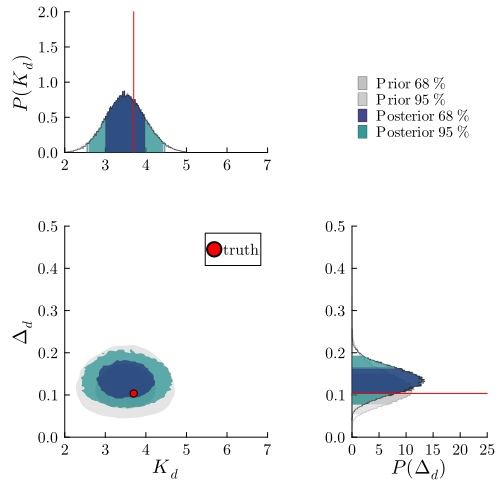

In [262]:

plot(framestyle=:axes, size=(500, 500), fontfamily=font_family, 
    layout=@layout([a b; c{0.6w, 0.6h} d]), grid=false)

# Joint posterior
plot!(prior_samples, (:(K_d), :(θ[2])), xlabel=L"K_d", ylabel=L"\Delta_d",
    seriestype=:smallest_intervals_contourf, smoothing=4, 
    marginalmode=false, intervals=intervals, fillcolors=reverse(prior_colors), linewidth=0, 
    alpha=prior_alpha,
    subplot=3)
plot!(samples_data, (:(K_d), :(θ[2])), xlabel=L"K_d", ylabel=L"\Delta_d",
    seriestype=:smallest_intervals_contourf, smoothing=2, 
    marginalmode=false, intervals=intervals, fillcolors=reverse(colors), linewidth=0, alpha=alpha,
    subplot=3, xlims=xlims_K_d, ylims=xlims_D_d)
p = plot!([K_d_true],[θ_true[2]], color="red",subplot=3, seriestype=:scatter, label="truth", lw=1)


# K_d marginal
plot!(prior_samples, :K_d, legend=false, marginalmode=false, 
    seriestype=:smallest_intervals, intervals=intervals, 
    colors=prior_colors, subplot=1, alpha=prior_alpha)
plot!(samples_data, :K_d, legend=false, xlabel="", ylabel=L"P(K_d)", subplot=1, 
    xlims=xlims_K_u, ylims=(0, 2), seriestype=:smallest_intervals, 
    marginalmode=false, intervals=intervals, colors=colors, alpha=alpha)
vline!([K_d_true], color="red", label="truth", lw=1)

# Delta_u marginal
plot!(prior_samples, :(θ[2]), legend=false, marginalmode=false, 
    seriestype=:smallest_intervals, intervals=intervals,
    colors=prior_colors, subplot=4, alpha=prior_alpha, 
    orientation=:horizontal)
plot!(samples_data, :(θ[2]), legend=false, ylabel="", xlabel=L"P(\Delta_d)", 
    subplot=4, ylims=xlims_D_u, xlims=(0, 25), 
    seriestype=:smallest_intervals, intervals=intervals, marginalmode=false, 
    colors=colors, alpha=alpha, orientation=:horizontal)
hline!([θ_true[2]], color="red", label="truth", subplot=4, lw=1)

# Legend
plot!(prior_samples, (:(K_d), :(θ[2])), xlabel=L"K_d", ylabel=L"\Delta_d",
    seriestype=:smallest_intervals,
    marginalmode=false, intervals=intervals, interval_labels=prior_labels, 
    colors=reverse(prior_colors), linewidth=0, 
    alpha=prior_alpha+0.2,
    subplot=2)
p = plot!(samples_data, (:(K_d), :(θ[2])),
    seriestype=:smallest_intervals,
    marginalmode=false, intervals=intervals, colors=reverse(colors), 
    interval_labels=labels,
    linewidth=0, alpha=alpha+0.2, legend=:bottomleft, foreground_color_legend=false,
    framestyle=:none, subplot=2, xlims=(0, 1.), ylims=(0, 0.1))



In [263]:
filename = string("fig2-d-", seedtxt, ".pdf")
savefig(filename)

"/Users/AllenCCaldwell/F2/PRDpaper/fig2-d-42.pdf"

In [264]:
prior_color = :grey40
prior_alpha = 0.2
posterior_color = c2
posterior_alpha = 0.7
bins = 60

60

In [265]:
# Combine results for Δ_sea and Δ_g
# NB: for sea, our θ for quark/antiquark are already x2 - no need to do so here!
# in our x_q_x() in parametrisations_base.jl we take the input θ and halve it. 
comb_prior_samples = bat_transform(v -> (Δ_g = v.θ[3] + v.θ[4], Δ_sea = sum(v.θ[5:9])), prior_samples).result
comb_samples = bat_transform(v -> (Δ_g = v.θ[3] + v.θ[4], Δ_sea = sum(v.θ[5:9])), samples_data).result;

[ Info: Using transform algorithm BAT.SampleTransformation()
[ Info: Using transform algorithm BAT.SampleTransformation()


In [266]:
plot(framestyle=:axes, size=(600, 500), fontfamily=font_family, 
    layout=@layout([a b; c d]), grid=false)

# Delta_u 
plot!(prior_samples, :(θ[1]), legend=false, marginalmode=false, 
    seriestype=:histogram, fillcolor=prior_color, subplot=1, alpha=prior_alpha, bins=bins, label=L"~~\mathrm{Prior}")
vline!([θ_true[1]], subplot=1, color="red", label="truth", lw=1)
plot!(samples_data, :(θ[1]), legend=false, ylabel=L"P(\Delta_u)", xlabel=L"\Delta_u",
    subplot=1, ylims=(0, 50), xlims=(0.0, 0.5), bins=bins,
    seriestype=:histogram, marginalmode=false, fillcolor=posterior_color, alpha=posterior_alpha, label=L"~~\mathrm{Posterior}")
plot!(legend=:topright,  foreground_color_legend=false)


# Delta_d
plot!(prior_samples, :(θ[2]), legend=false, marginalmode=false, 
    seriestype=:histogram, fillcolor=prior_color, subplot=2, alpha=prior_alpha, bins=bins)
plot!(samples_data, :(θ[2]), legend=false, ylabel=L"P(\Delta_d)", xlabel=L"\Delta_d",
    subplot=2, ylims=(0, 20), xlims=(0.0, 0.5), bins=bins,
    seriestype=:histogram, marginalmode=false, fillcolor=posterior_color, alpha=posterior_alpha)
vline!([θ_true[2]], subplot=2, color="red", label="truth", lw=1)

# Delta_sea 
Δ_sea_true = sum(θ_true[5:9])
plot!(comb_prior_samples, :(Δ_sea), legend=false, marginalmode=false, 
    seriestype=:histogram, fillcolor=prior_color, subplot=3, alpha=prior_alpha, bins=bins)
plot!(comb_samples, :(Δ_sea), legend=false, ylabel=L"P(\Delta_\mathrm{sea})", xlabel=L"\Delta_\mathrm{sea}",
    subplot=3, ylims=(0, 20), xlims=(0.0, 0.5), bins=bins,
    seriestype=:histogram, marginalmode=false, fillcolor=posterior_color, alpha=posterior_alpha)
vline!([Δ_sea_true], subplot=3, color="red", label="truth", lw=1)

# Gluon 
Δ_g_true = sum(θ_true[3:4])

plot!(comb_prior_samples, :(Δ_g), legend=false, marginalmode=false,
    seriestype=:histogram, fillcolor=prior_color, subplot=4, alpha=prior_alpha, bins=bins)
p = plot!(comb_samples, :(Δ_g), legend=false, ylabel=L"P(\Delta_g)", xlabel=L"\Delta_g", 
    subplot=4, ylims=(0, 15), xlims=(0.0, 1.0), bins=bins,
    seriestype=:histogram, marginalmode=false, fillcolor=posterior_color, alpha=posterior_alpha)
vline!([Δ_g_true], subplot=4, color="red", label="truth", lw=1)


In [267]:
filename = string("Momenta-", seedtxt, ".pdf")
savefig(filename)

"/Users/AllenCCaldwell/F2/PRDpaper/Momenta-42.pdf"

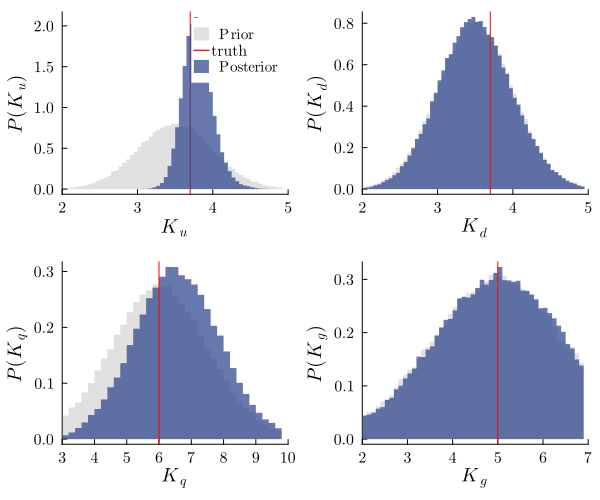

In [268]:
plot(framestyle=:axes, size=(600, 500), fontfamily=font_family, 
    layout=@layout([a b; c d]), grid=false)

# K_u 
plot!(prior_samples, :(K_u), legend=false, marginalmode=false, 
    seriestype=:histogram, fillcolor=prior_color, subplot=1, alpha=prior_alpha, bins=bins, label=L"~~\mathrm{Prior}")
vline!([K_u_true], subplot=1, color="red", label="truth", lw=1)
plot!(samples_data, :(K_u), legend=false, ylabel=L"P(K_u)", xlabel=L"K_u",
    subplot=1, xlims=(2.0, 5.0), bins=bins,
    seriestype=:histogram, marginalmode=false, fillcolor=posterior_color, alpha=posterior_alpha, label=L"~~\mathrm{Posterior}")
plot!(legend=:topright,  foreground_color_legend=false)


# K_d
plot!(prior_samples, :(K_d), legend=false, marginalmode=false, 
    seriestype=:histogram, fillcolor=prior_color, subplot=2, alpha=prior_alpha, bins=bins)
plot!(samples_data, :(K_d), legend=false, ylabel=L"P(K_d)", xlabel=L"K_d",
    subplot=2, xlims=(2.0, 5.0), bins=bins,
    seriestype=:histogram, marginalmode=false, fillcolor=posterior_color, alpha=posterior_alpha)
vline!([K_d_true], subplot=2, color="red", label="truth", lw=1)

# K_sea 
plot!(prior_samples, :(K_q), legend=false, marginalmode=false, 
    seriestype=:histogram, fillcolor=prior_color, subplot=3, alpha=prior_alpha, bins=bins)
plot!(samples_data, :(K_q), legend=false, ylabel=L"P(K_q)", xlabel=L"K_q",
    subplot=3, xlims=(3.0,10.0), bins=bins,
    seriestype=:histogram, marginalmode=false, fillcolor=posterior_color, alpha=posterior_alpha)
vline!([K_q_true], subplot=3, color="red", label="truth", lw=1)

# K_Gluon 

plot!(prior_samples, :(K_g), legend=false, marginalmode=false,
    seriestype=:histogram, fillcolor=prior_color, subplot=4, alpha=prior_alpha, bins=bins)
p = plot!(samples_data, :(K_g), legend=false, ylabel=L"P(K_g)", xlabel=L"K_g", 
    subplot=4, xlims=(2.0, 7.0), bins=bins,
    seriestype=:histogram, marginalmode=false, fillcolor=posterior_color, alpha=posterior_alpha)
vline!([K_g_true], subplot=4, color="red", label="truth", lw=1)


In [269]:
filename = string("K-", seedtxt, ".pdf")
savefig(filename)

"/Users/AllenCCaldwell/F2/PRDpaper/K-42.pdf"

[ Info: Using transform algorithm BAT.SampleTransformation()
[ Info: Using transform algorithm BAT.SampleTransformation()
[ Info: Using transform algorithm BAT.SampleTransformation()
[ Info: Using transform algorithm BAT.SampleTransformation()
[ Info: Using transform algorithm BAT.SampleTransformation()
[ Info: Using transform algorithm BAT.SampleTransformation()


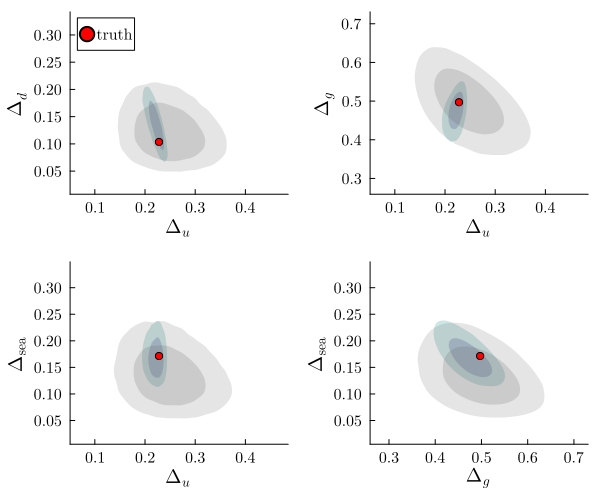

In [270]:
plot(framestyle=:axes, size=(600, 500), fontfamily=font_family, 
    layout=@layout([a b; c d]), grid=false)
plot!(samples_data, (:(θ[1]), :(θ[2])), subplot=1, xlabel=L"\Delta_{u}", ylabel=L"\Delta_{d}",
   seriestype=:smallest_intervals_contourf, smoothing=4, 
    marginalmode=false, intervals=intervals, fillcolors=reverse(colors), linewidth=0, 
    alpha=prior_alpha)
plot!(prior_samples, (:(θ[1]), :(θ[2])), subplot=1, xlabel=L"\Delta_{u}", ylabel=L"\Delta_{d}",
   seriestype=:smallest_intervals_contourf, smoothing=4, 
    marginalmode=false, intervals=intervals, fillcolors=reverse(prior_colors), linewidth=0, 
    alpha=prior_alpha)
plot!([θ_true[1]],[θ_true[2]], subplot=1, color="red",seriestype=:scatter, label="truth", lw=0.5)

comb_prior_samples = bat_transform(v -> (Δ_g = v.θ[3] + v.θ[4], Δ_u = v.θ[1]), prior_samples).result
comb_samples = bat_transform(v -> (Δ_g = v.θ[3] + v.θ[4], Δ_u = v.θ[1]), samples_data).result;

plot!(comb_samples, (:(Δ_u), :(Δ_g)),subplot=2,xlabel=L"\Delta_{u}", ylabel=L"\Delta_{g}",
   seriestype=:smallest_intervals_contourf, smoothing=4, 
    marginalmode=false, intervals=intervals, fillcolors=reverse(colors), linewidth=0, 
    alpha=prior_alpha)
plot!(comb_prior_samples, (:(Δ_u), :(Δ_g)), subplot=2,xlabel=L"\Delta_{u}", ylabel=L"\Delta_{g}",
   seriestype=:smallest_intervals_contourf, smoothing=4, 
    marginalmode=false, intervals=intervals, fillcolors=reverse(prior_colors), linewidth=0, 
    alpha=prior_alpha)
θ_g_true=θ_true[3]+θ_true[4]
plot!([θ_true[1]],[θ_g_true], subplot=2,color="red",seriestype=:scatter, label=:none, lw=1)


comb_prior_samples = bat_transform(v -> (Δ_sea = sum(v.θ[5:9]), Δ_u = v.θ[1]), prior_samples).result
comb_samples = bat_transform(v -> (Δ_sea = sum(v.θ[5:9]), Δ_u = v.θ[1]), samples_data).result;

plot!(comb_samples, (:(Δ_u), :(Δ_sea)),subplot=3,xlabel=L"\Delta_{u}", ylabel=L"\Delta_\mathrm{sea}",
   seriestype=:smallest_intervals_contourf, smoothing=4, 
    marginalmode=false, intervals=intervals, fillcolors=reverse(colors), linewidth=0, 
    alpha=prior_alpha)
plot!(comb_prior_samples, (:(Δ_u), :(Δ_sea)), subplot=3,xlabel=L"\Delta_{u}", ylabel=L"\Delta_\mathrm{sea}",
   seriestype=:smallest_intervals_contourf, smoothing=4, 
    marginalmode=false, intervals=intervals, fillcolors=reverse(prior_colors), linewidth=0, 
    alpha=prior_alpha)
θ_sea_true=sum(θ_true[5:9])
plot!([θ_true[1]],[θ_sea_true], subplot=3,color="red",seriestype=:scatter, label=:none, lw=1)


comb_prior_samples = bat_transform(v -> (Δ_sea = sum(v.θ[5:9]), Δ_g = v.θ[3] + v.θ[4]), prior_samples).result
comb_samples = bat_transform(v -> (Δ_sea = sum(v.θ[5:9]), Δ_g = v.θ[3] + v.θ[4]), samples_data).result;

plot!(comb_samples, (:(Δ_g), :(Δ_sea)),subplot=4, xlabel=L"\Delta_{g}", ylabel=L"\Delta_\mathrm{sea}",
   seriestype=:smallest_intervals_contourf, smoothing=4, 
    marginalmode=false, intervals=intervals, fillcolors=reverse(colors), linewidth=0, 
    alpha=prior_alpha)
plot!(comb_prior_samples, (:(Δ_g), :(Δ_sea)),subplot=4,xlabel=L"\Delta_{g}", ylabel=L"\Delta_\mathrm{sea}",
   seriestype=:smallest_intervals_contourf, smoothing=4, 
    marginalmode=false, intervals=intervals, fillcolors=reverse(prior_colors), linewidth=0, 
    alpha=prior_alpha)

plot!([Δ_g_true],[Δ_sea_true], color="red",subplot=4,seriestype=:scatter, label=:none, lw=1)


In [271]:
filename = string("momentum-corr-", seedtxt, ".pdf")
savefig(filename)

"/Users/AllenCCaldwell/F2/PRDpaper/momentum-corr-42.pdf"

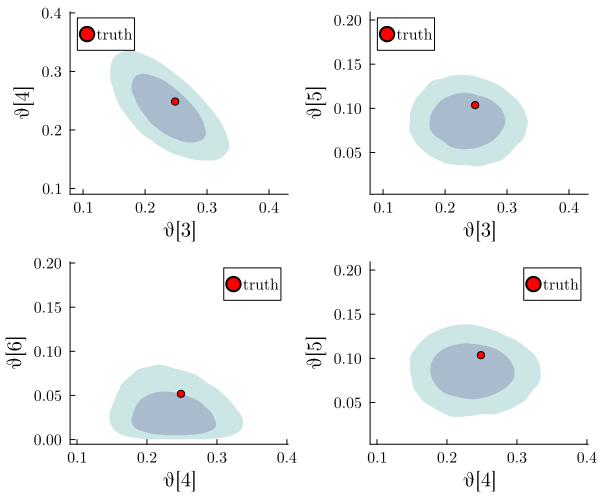

In [272]:
plot(framestyle=:axes, size=(600, 500), fontfamily=font_family, 
    layout=@layout([a b; c d]), grid=false)
plot!(samples_data, (:(θ[3]), :(θ[4])), subplot=1,
   seriestype=:smallest_intervals_contourf, smoothing=4, 
    marginalmode=false, intervals=intervals, fillcolors=reverse(colors), linewidth=0, 
    alpha=prior_alpha)
plot!([θ_true[3]],[θ_true[4]], subplot=1, color="red",seriestype=:scatter, label="truth", lw=1)
plot!(samples_data, (:(θ[3]), :(θ[5])),subplot=2,
   seriestype=:smallest_intervals_contourf, smoothing=4, 
    marginalmode=false, intervals=intervals, fillcolors=reverse(colors), linewidth=0, 
    alpha=prior_alpha)
plot!([θ_true[3]],[θ_true[5]], subplot=2,color="red",seriestype=:scatter, label="truth", lw=1)

plot!(samples_data, (:(θ[4]), :(θ[6])),subplot=3,
   seriestype=:smallest_intervals_contourf, smoothing=4, 
    marginalmode=false, intervals=intervals, fillcolors=reverse(colors), linewidth=0, 
    alpha=prior_alpha)
plot!([θ_true[4]],[θ_true[6]], subplot=3,color="red",seriestype=:scatter, label="truth", lw=1)
plot!(samples_data, (:(θ[4]), :(θ[5])),subplot=4,
   seriestype=:smallest_intervals_contourf, smoothing=4, 
    marginalmode=false, intervals=intervals, fillcolors=reverse(colors), linewidth=0, 
    alpha=prior_alpha)
plot!([θ_true[4]],[θ_true[5]], subplot=4,color="red",seriestype=:scatter, label="truth", lw=1)


In [273]:

function x_uv_x(x::Real, λ_u::Real, K_u::Real)

    A_u = 2 / sf.beta(λ_u, K_u + 1)

    return A_u * x^λ_u * (1 - x)^K_u

end

function x_dv_x(x::Real, λ_d::Real, K_d::Real)

    A_d = 1 / sf.beta(λ_d, K_d + 1)

    return A_d * x^λ_d * (1 - x)^K_d

end

function x_g_x(x::Real, λ_g1::Real, λ_g2::Real, K_g::Real,
    K_q::Real, w1::Real, w2::Real)

    A_g1 = w1 / sf.beta(λ_g1 + 1, K_g + 1)

    x_g1_x = A_g1 * x^λ_g1 * (1 - x)^K_g

    A_g2 = w2 / sf.beta(λ_g2 + 1, K_q + 1)

    x_g2_x = A_g2 * x^λ_g2 * (1 - x)^K_q

    return x_g1_x + x_g2_x

end

function x_q_x(x::Real, λ_q::Real, K_q::Real, w::Real)

    A_q = (w / 2) / sf.beta(λ_q + 1, K_q + 1)

    return A_q * x^λ_q * (1 - x)^K_q

end


x_q_x (generic function with 1 method)

In [274]:
function wrap_xuval(p::NamedTuple, x::Real)
    
    pdf_p = DirichletPDFParams(K_u=p.K_u, K_d=p.K_d, λ_g1=p.λ_g1, K_q=p.K_q, 
                                    λ_g2=p.λ_g2, K_g=p.K_g, λ_q=p.λ_q, θ=p.θ)
    return PartonDensity.x_uv_x(x,pdf_p.λ_u, pdf_p.K_u)
end

function wrap_xdval(p::NamedTuple, x::Real)
    
    pdf_p = DirichletPDFParams(K_u=p.K_u, K_d=p.K_d, λ_g1=p.λ_g1, K_q=p.K_q, 
                                    λ_g2=p.λ_g2, K_g=p.K_g, λ_q=p.λ_q, θ=p.θ)
    return PartonDensity.x_dv_x(x,pdf_p.λ_d, pdf_p.K_d)
end

function wrap_xg(p::NamedTuple, x::Real)
    
    scale = 0.1
    pdf_p = DirichletPDFParams(K_u=p.K_u, K_d=p.K_d, λ_g1=p.λ_g1, K_q=p.K_q,
                                    λ_g2=p.λ_g2, K_g=p.K_g, λ_q=p.λ_q, θ=p.θ)
    return PartonDensity.x_g_x(x, pdf_p.λ_g1, pdf_p.λ_g2, pdf_p.K_g, pdf_p.K_q, pdf_p.θ[3], pdf_p.θ[4]) * scale
end

function wrap_xsea(p::NamedTuple, x::Real)
    
    scale = 0.1
    pdf_p = DirichletPDFParams(K_u=p.K_u, K_d=p.K_d, λ_g1=p.λ_g1, K_q=p.K_q,
                                    λ_g2=p.λ_g2, K_g=p.K_g, λ_q=p.λ_q, θ=p.θ)

    x_ubar_x = PartonDensity.x_q_x(x, pdf_p.λ_q, pdf_p.K_q, pdf_p.θ[5])
    x_dbar_x = PartonDensity.x_q_x(x, pdf_p.λ_q, pdf_p.K_q, pdf_p.θ[6])
    x_sbar_x = PartonDensity.x_q_x(x, pdf_p.λ_q, pdf_p.K_q, pdf_p.θ[7])
    x_cbar_x = PartonDensity.x_q_x(x, pdf_p.λ_q, pdf_p.K_q, pdf_p.θ[8])
    x_bbar_x = PartonDensity.x_q_x(x, pdf_p.λ_q, pdf_p.K_q, pdf_p.θ[9])

    return 2 * (x_ubar_x + x_dbar_x + x_sbar_x + x_cbar_x + x_bbar_x) * scale
end
     


wrap_xsea (generic function with 1 method)

[ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}


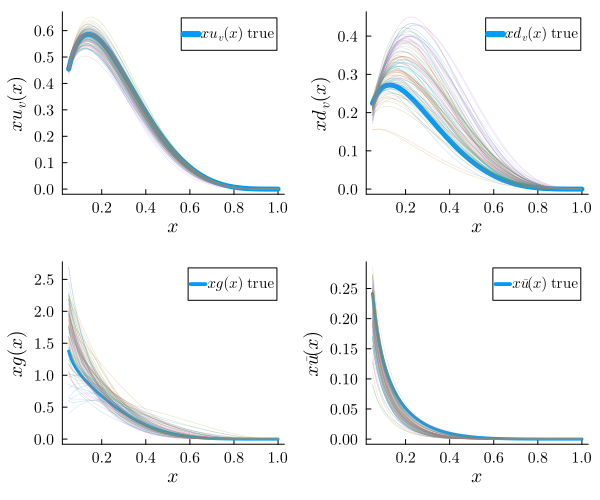

In [275]:
    x_grid = range(0.05, 1.0, length=95)

plot(framestyle=:axes, size=(600, 500), fontfamily=font_family, 
    layout=@layout([a b; c d]), grid=false)


λ_u_true = θ_true[1]*(1+K_u_true)/(2-θ_true[1])
p = plot!(x_grid, [x_uv_x(x, λ_u_true, K_u_true) for x in x_grid], label=L"xu_v(x) \; \mathrm{true}", lw=5, subplot=1)

Ns = 100 # Number of samples from posterior
sub_samples = BAT.bat_sample(samples_data, BAT.OrderedResampling(nsamples=Ns)).result;
for s in eachindex(sub_samples)

    pdf_params_s = DirichletPDFParams(K_u=sub_samples.v.K_u[s], K_d=sub_samples.v.K_d[s], K_q=sub_samples.v.K_q[s],
                                      λ_g1=sub_samples.v.λ_g1[s], 
                                      λ_g2=sub_samples.v.λ_g2[s],
                                      K_g=sub_samples.v.K_g[s], 
                                      λ_q=sub_samples.v.λ_q[s], 
                                      θ=Vector(sub_samples.v.θ[s]))
    λ_u= pdf_params_s.θ[1]*(1+pdf_params_s.K_u)/(2-pdf_params_s.θ[1])

    plot!(x_grid, [x_uv_x(x, λ_u, pdf_params_s.K_u) for x in x_grid],lw=0.5,alpha=0.3,label=:none, subplot=1)

end

    p = plot!(xlabel=L"x", ylabel=L"xu_v(x)", subplot=1)



#
λ_d_true = θ_true[2]*(1+K_d_true)/(1-θ_true[2])

p = plot!(x_grid, [x_dv_x(x, λ_d_true, K_d_true) for x in x_grid], label=L"xd_v(x) \; \mathrm{true}", lw=5, subplot=2)


for s in eachindex(sub_samples)
    

    pdf_params_s = DirichletPDFParams(K_u=sub_samples.v.K_u[s], K_d=sub_samples.v.K_d[s], K_q=sub_samples.v.K_q[s],
                                      λ_g1=sub_samples.v.λ_g1[s], 
                                      λ_g2=sub_samples.v.λ_g2[s],
                                      K_g=sub_samples.v.K_g[s], 
                                      λ_q=sub_samples.v.λ_q[s], 
                                      θ=Vector(sub_samples.v.θ[s]))
    
        λ_d= pdf_params_s.θ[2]*(1+pdf_params_s.K_d)/(1-pdf_params_s.θ[2])

    plot!(x_grid, [x_dv_x(x, λ_d, pdf_params_s.K_d) for x in x_grid],lw=0.5,alpha=0.3,label=:none, subplot=2)

end

    p = plot!(xlabel=L"x", ylabel=L"xd_v(x)", subplot=2)


#


    p = plot!(x_grid, [x_g_x(x, pdf_params.λ_g1, pdf_params.λ_g2, pdf_params.K_g, pdf_params.K_q, pdf_params.θ[3], pdf_params.θ[4])
                       for x in x_grid], label=L"xg(x) \; \mathrm{true}", lw=3, subplot=3)


for s in eachindex(sub_samples)
    
   pdf_params_s = DirichletPDFParams(K_u=sub_samples.v.K_u[s], K_d=sub_samples.v.K_d[s], K_q=sub_samples.v.K_q[s],
                                      λ_g1=sub_samples.v.λ_g1[s], 
                                      λ_g2=sub_samples.v.λ_g2[s],
                                      K_g=sub_samples.v.K_g[s], 
                                      λ_q=sub_samples.v.λ_q[s], 
                                      θ=Vector(sub_samples.v.θ[s]))

    p = plot!(x_grid, [x_g_x(x, pdf_params_s.λ_g1, pdf_params_s.λ_g2, pdf_params_s.K_g, pdf_params_s.K_q, pdf_params_s.θ[3], pdf_params_s.θ[4])
                       for x in x_grid], lw=0.5,alpha=0.3,label=:none,subplot=3)
end

    p = plot!(xlabel=L"x", ylabel=L"xg(x)", subplot=3)

#
    p = plot!(x_grid, [x_q_x(x, pdf_params.λ_q, pdf_params.K_q, pdf_params.θ[5]) for x in x_grid], label=L"x\bar{u}(x) \; \mathrm{true}", lw=3, subplot=4)




for s in eachindex(sub_samples)
    
   pdf_params_s = DirichletPDFParams(K_u=sub_samples.v.K_u[s], K_d=sub_samples.v.K_d[s], K_q=sub_samples.v.K_q[s],
                                      λ_g1=sub_samples.v.λ_g1[s], 
                                      λ_g2=sub_samples.v.λ_g2[s],
                                      K_g=sub_samples.v.K_g[s], 
                                      λ_q=sub_samples.v.λ_q[s], 
                                      θ=Vector(sub_samples.v.θ[s]))


        p = plot!(x_grid, [x_q_x(x, pdf_params_s.λ_q, pdf_params_s.K_q, pdf_params_s.θ[5]) for x in x_grid], lw=0.5,alpha=0.3,label=:none,subplot=4)

end

    p = plot!(xlabel=L"x", ylabel=L"x\bar{u}(x)", subplot=4)

 #   p = plot!(x_grid, [x_g_x(x, mode_pars_data.λ_g1, mode_pars_data.λ_g2, mode_pars_data.K_g, mode_pars_data.K_q, mode_pars_data.θ_tmp[1], mode_pars_data.θ_tmp[2])
 #                      for x in x_grid], label="x g(x)", lw=3, subplot=3)

In [276]:
filename = string("parton-xf(x)-", seedtxt, ".pdf")
savefig(filename)

"/Users/AllenCCaldwell/F2/PRDpaper/parton-xf(x)-42.pdf"

[ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
[ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}


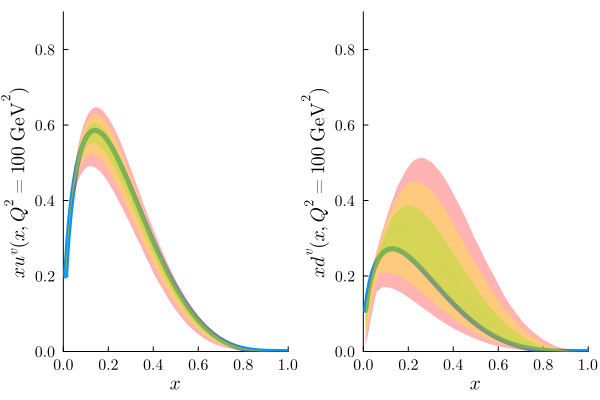

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:99.
└ @ Plots ~/.julia/packages/Plots/B5j7d/src/utils.jl:141
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:99.
└ @ Plots ~/.julia/packages/Plots/B5j7d/src/utils.jl:141
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:99.
└ @ Plots ~/.julia/packages/Plots/B5j7d/src/utils.jl:141
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:99.
└ @ Plots ~/.julia/packages/Plots/B5j7d/src/utils.jl:141
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:99.
└ @ Plots ~/.julia/packages/Plots/B5j7d/src/utils.jl:141
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:99.
└ @ Plots ~/.julia/packages/Plots/B5j7d/src/utils.jl:141
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:99.


In [277]:
    x_grid = range(0.01, 1.0, length=99)

plot(framestyle=:axes, size=(600, 500), fontfamily=font_family, 
    layout=@layout([a b]), grid=false)


λ_u_true = θ_true[1]*(1+K_u_true)/(2-θ_true[1])
p = plot!(x_grid, [x_uv_x(x, λ_u_true, K_u_true) for x in x_grid], label=L"xu_v(x) \; \mathrm{true}", lw=5, subplot=1)

plot!(x_grid, wrap_xuval, samples_data, ylabel=L"xu^v(x,Q^2=100~\mathrm{GeV}^2)",
    global_mode=false, median=false, legend=false, conf_intervals=[0.68],
    xlims=(0, 1), ylims=(0, 0.9), fillalpha=0.3, 
    linewidth=0, xlabel=L"x", color=[c3], subplot=1)



#
λ_d_true = θ_true[2]*(1+K_d_true)/(1-θ_true[2])

p = plot!(x_grid, [x_dv_x(x, λ_d_true, K_d_true) for x in x_grid], label=L"xd_v(x) \; \mathrm{true}", lw=5, subplot=2)


plot!(x_grid, wrap_xdval, samples_data, ylabel=L"xd^v(x,Q^2=100~\mathrm{GeV}^2)",
    global_mode=false, median=false, legend=false, conf_intervals=[0.68],
    xlims=(0, 1), ylims=(0, 0.9), fillalpha=0.3, 
    linewidth=0, xlabel=L"x", color=[c3], subplot=2)




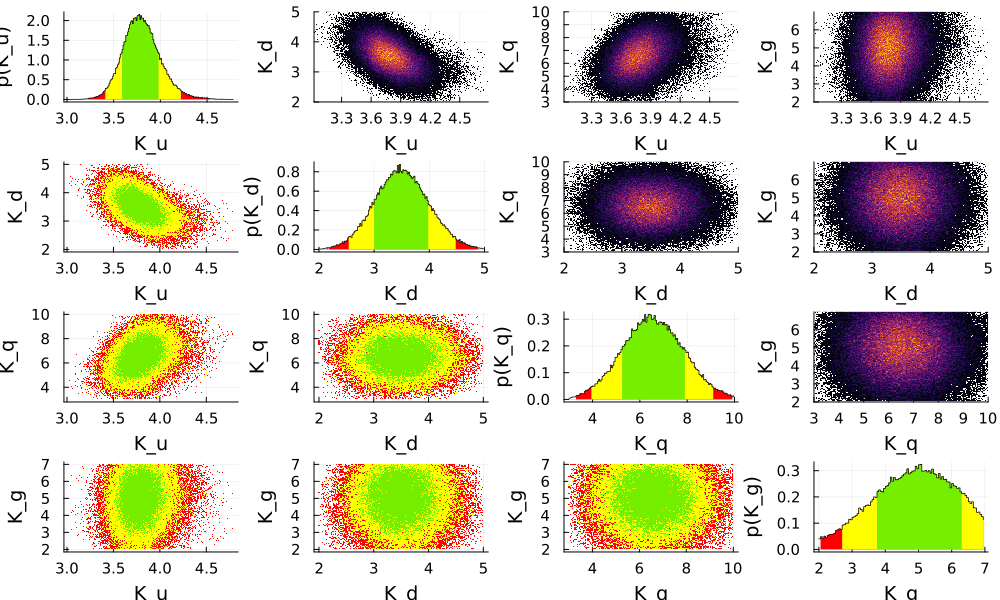

In [278]:
plot(samples_data,vsel=[:K_u,:K_d, :K_q, :K_g])

In [279]:
filename = string("corner-", seedtxt, ".pdf")
savefig(filename)

"/Users/AllenCCaldwell/F2/PRDpaper/corner-42.pdf"